# Spec2Vec - Search for matching compounds in a spectral library
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.

## Scenario 1:
- Match 1000 query spectra.
- For all query spectra we have >= 1 spectrum of same InChIKey in the library
- filter matches using precursor m/z match (within 1ppm)

In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "AllPositive"

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 112956


In [2]:
# alternative (faster)
import pickle
outfile = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.pickle')
with open(outfile, 'rb') as file:
    spectrums = pickle.load(file)

Text(0, 0.5, 'number of spectra in respective bin')

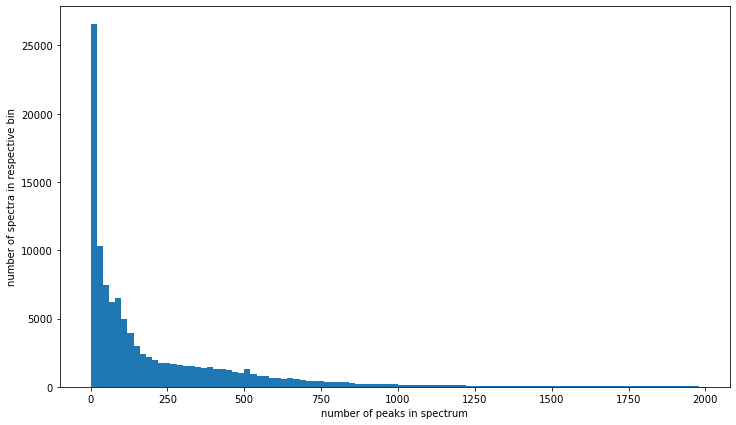

In [3]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

## Post-process data
We here do different post-processing for either the "classical" scores (Cosine, modified Cosine) or Spe2Vec. The reason for this is mostly to make sure that we do full justice to the classical similarity measures.

#### Post-processing for classical scores
Cosine and modified cosine scores are build on multiplying intensities of matching peaks. Small peaks (<0.01) hence contribute very little to the final scores and are left out to avoid excessive computation times. 
+ normalize peaks (maximum intensity to 1)
+ remove peaks outside [0, 1000] m/z window
+ remove spectra with < 10 peaks
+ remove peaks with intensities < 0.01 of maximum intensity.

#### Post-processing for Spec2Vec
Spec2Vec similarity scores rely on creating a ``document vector`` for each spectrum. For the underlying word2vec model we want the documents (=spectra) to be more homogeneous in their number of unique words. Assuming that larger compounds will on average break down into a higher number of meaningful fragment peaks we reduce the document size of each spectrum according to its parent mass.
+ normalize peaks (maximum intensity to 1)
+ remove peaks outside [0, 1000] m/z window
+ remove spectra with < 10 peaks
+ reduce number of peaks to maximum of 0.5 * parent mass
+ remove peaks with intensities < 0.001 of maximum intensity (unless this brings number of peaks to less than 10)

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process_classical(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

# apply filters to the data
spectrums_classical = [post_process_classical(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_classical = [s for s in spectrums_classical if s is not None]

print("{} remaining spectra.".format(len(spectrums_classical)))

95320 remaining spectra.


In [6]:
import pickle
pickle.dump(spectrums_classical, 
            open(os.path.join(path_data,'gnps_positive_ionmode_processed_classical.pickle'), "wb"))

In [2]:
import pickle
outfile = os.path.join(path_data,'gnps_positive_ionmode_processed_classical.pickle')
with open(outfile, 'rb') as file:
    spectrums_classical = pickle.load(file)

In [5]:
def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

print("{} remaining spectra.".format(len(spectrums_s2v)))

95320 remaining spectra.


In [7]:
import pickle
pickle.dump(spectrums_s2v, 
            open(os.path.join(path_data,'gnps_positive_ionmode_processed_s2v.pickle'), "wb"))

In [3]:
import pickle
outfile = os.path.join(path_data,'gnps_positive_ionmode_processed_s2v.pickle')
with open(outfile, 'rb') as file:
    spectrums_s2v = pickle.load(file)

Text(0, 0.5, 'number of spectra in respective bin')

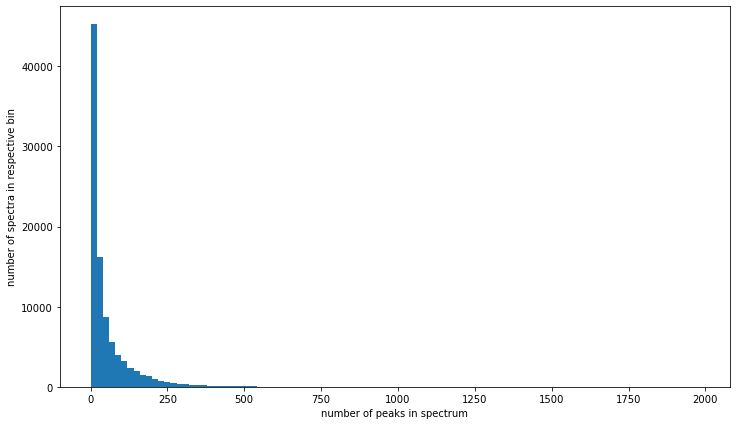

In [8]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_classical]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

In [9]:
np.max(number_of_peaks)

42049

Text(0, 0.5, 'number of spectra in respective bin')

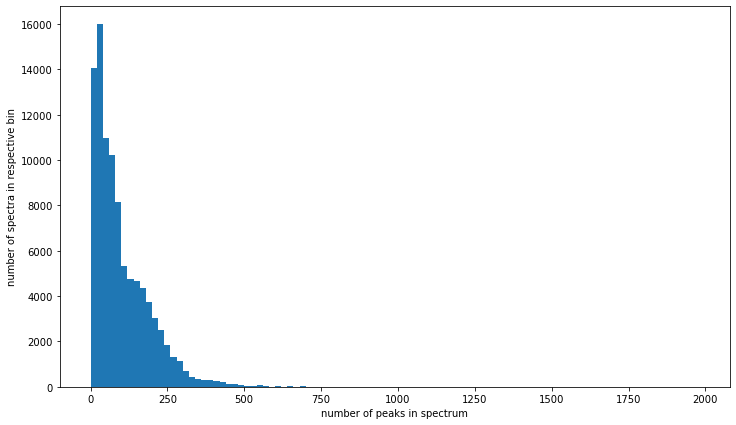

In [10]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_s2v]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

In [11]:
np.max(number_of_peaks)

1081

## Inspect annotations

In [6]:
Inchikeys = []
for spec in spectrums_classical:
    Inchikeys.append(spec.get("inchikey"))

inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd.str[:14].value_counts()[:20]

NEGQHKSYEYVFTD    432
SULIDBRAXVDKBU    426
IQGPMZRCLCCXAG    308
WTJKGGKOPKCXLL    295
IIZPXYDJLKNOIY    235
RWKUXQNLWDTSLO    234
QIBZFHLFHCIUOT    225
ZAYXPDDGEIJGGW    212
QJWDAOSZZYVBJZ    210
KILNVBDSWZSGLL    205
RFVFQQWKPSOBED    202
IESVDEZGAHUQJU    197
LFUDDCMNKWEORN    195
JLPULHDHAOZNQI    182
LSOWKZULVQWMLY    180
XGGMHQYOVYWRLV    178
LLHISNQVRRYJGL    175
JFISYPWOVQNHLS    174
SRIGHEHXEGELQJ    166
ACTIUHUUMQJHFO    163
dtype: int64

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

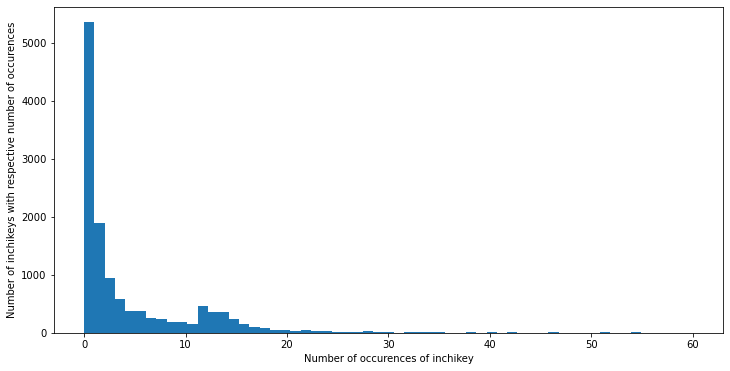

In [16]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), np.linspace(0, 60, 60))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

### Randomly select 1000 inchikeys that exist >=2  times in the dataset

In [7]:
min_copies_in_data = 2

suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= min_copies_in_data])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.head(15)

,inchikey14,occurences
0,NEGQHKSYEYVFTD,432
1,SULIDBRAXVDKBU,426
2,IQGPMZRCLCCXAG,308
3,WTJKGGKOPKCXLL,295
4,IIZPXYDJLKNOIY,235
5,RWKUXQNLWDTSLO,234
6,QIBZFHLFHCIUOT,225
7,ZAYXPDDGEIJGGW,212
8,QJWDAOSZZYVBJZ,210
9,KILNVBDSWZSGLL,205


In [8]:
print(f"Number of spectra with inchikeys that exist >= {min_copies_in_data} times:", suitable_inchikeys.shape[0])

Number of spectra with inchikeys that exist >= 2 times: 7494


In [9]:
num_spectra = 1000
np.random.seed(42) # to make it reproducible

selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:25])
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:25]

[6416 5432 6575 5850 4776 6263 5502 7354 6711 6477  263 6261 4650 4257
 2927  101 4201 2302 3844 3686 3622 3454 1215 2471 4420]


array(['OUDSBRTVNLOZBN', 'DYTVYDVNJBXBMW', 'MSKAFRMBWXTPHY',
       'WWBNBPSEKLOHJU', 'WVILKFILAZPSRT', 'QWYFHHGCZUCMBN',
       'CEUORZQYGODEFX', 'BSLDUMMCFUUGHA', 'KXPXJGYSEPEXMF',
       'NYQQFKYIZVRSQX', 'OVMSOCFBDVBLFW', 'QXUANCZURDYUIT',
       'AHUAGKUYEMQHTH', 'RVFHMABKCYSPEE', 'RFWGABANNQMHMZ',
       'KMPWYEUPVWOPIM', 'UPEZCKBFRMILAV', 'BJRNKVDFDLYUGJ',
       'PLDCWKCPEXNWJH', 'AXAACNNFMJZAGJ', 'GFMGOVRWOOAPMN',
       'RSIWXFIBHXYNFM', 'UGJMXCAKCUNAIE', 'AFDANKUHSLVEBJ',
       'KOPJPWSRYZRWPD'], dtype=object)

### Inspect number of library spectra with same InChIKey as queries

In [47]:
inchikeys14_array = np.array([x[:14] for x in Inchikeys if x is not None])
number_of_copies = []

for inchikey in selected_inchikeys:
    number_of_copies.append(len(np.where(inchikeys14_array == inchikey)[0]))

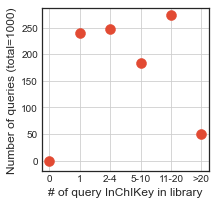

In [69]:
plt.figure(figsize=(3,3))
plt.style.use('seaborn-white')
bins = [0, 1.5, 2.5, 5.5, 11.5, 21.5, 101.5]
labels = ["0", "1", "2-4", "5-10", "11-20", ">20"]
a, b = np.histogram(number_of_copies, bins)
plt.scatter(labels, a, s=100)
plt.ylabel('Number of queries (total=1000)')
plt.xlabel('# of query InChIKey in library')
plt.ylim(-20)
plt.grid(True)
plt.savefig("library_matching_scenario1_library_condition.svg")

### Randomly pick one spectra for each of the chosen inchikeys

In [10]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!

np.random.seed(42) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [11]:
selected_spectra[:10]

[8077, 9473, 7806, 94073, 1245, 20130, 21615, 12562, 17979, 51462]

In [12]:
# Show gnps IDs for selected spectra
for ID in selected_spectra[:10]:
    print(spectrums_s2v[ID].get("spectrumid"),
         spectrums_s2v[ID].get("inchikey")[:14])

CCMSLIB00000077076 OUDSBRTVNLOZBN
CCMSLIB00000845070 DYTVYDVNJBXBMW
CCMSLIB00000079122 MSKAFRMBWXTPHY
CCMSLIB00000221613 WWBNBPSEKLOHJU
CCMSLIB00000081257 WVILKFILAZPSRT
CCMSLIB00003134772 QWYFHHGCZUCMBN
CCMSLIB00003136430 CEUORZQYGODEFX
CCMSLIB00000850433 BSLDUMMCFUUGHA
CCMSLIB00000085902 KXPXJGYSEPEXMF
CCMSLIB00003127602 NYQQFKYIZVRSQX


## Train new model on AllPositive dataset WITHOUT selected spectra

In [13]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

In [14]:
documents_library_s2v = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_s2v) if i not in selected_spectra]

In [15]:
documents_library_classical = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_classical) if i not in selected_spectra]

In [16]:
len(documents_library_s2v), len(spectrums_s2v)  # 1000 should be removed

(94320, 95320)

In [31]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_librarymatching_201124.model")

iterations = [1, 3, 5, 10, 15, 20]

# Train model with default parameters
model = train_new_word2vec_model(documents_library_s2v, iterations, model_file)

  Epoch 1 of 20.Change in loss after epoch 1: 5831823.5
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_librarymatching_201124_iter_1.model
  Epoch 2 of 20.Change in loss after epoch 2: 4281100.5
  Epoch 3 of 20.Change in loss after epoch 3: 3768297.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_librarymatching_201124_iter_3.model
  Epoch 4 of 20.Change in loss after epoch 4: 3507255.0
  Epoch 5 of 20.Change in loss after epoch 5: 2875194.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_librarymatching_201124_iter_5.model
  Epoch 6 of 20.Change in loss after epoch 6: 2767770.0
  Epoch 7 of 20.Change in loss after epoch 7: 2654804.0
  Epoch 8 of 20.Change in loss after epoch 8: 2652482.0
  Epoch 9 of 20.Change in loss after epoch 9: 2581294.0
 

## Actual library matching

In [17]:
sys.path.insert(0, os.path.join(ROOT, "custom_functions"))

In [18]:
from library_search import library_matching

#### Load word2vec model

In [19]:
path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_librarymatching_201124_iter_15.model")
model = gensim.models.Word2Vec.load(model_file)

In [20]:
documents_query_s2v = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in selected_spectra]

In [21]:
documents_query_classical = [SpectrumDocument(spectrums_classical[i], n_decimals=2) for i in selected_spectra]

In [22]:
len(documents_query_s2v)

1000

In [23]:
documents_query_s2v[0]._obj.get("inchikey")

'OUDSBRTVNLOZBN-UHFFFAOYSA-N'

### Correct a few (< 10) spectrums with missing precursor_mz

In [24]:
for i, spec in enumerate(spectrums_classical):
    if not spec.get("precursor_mz"):
        print(i)
        fix_mass = 0.0
        for history in spec.metadata['annotation_history']:
            fix_mass_test = float(history['Precursor_MZ'])
            fix_mass = max(fix_mass, fix_mass_test)
        charge = spec.get("charge")
        protons_mass = 1.00727645199076 * charge
        precursor_mass = fix_mass * abs(charge)
        parent_mass = precursor_mass - protons_mass
        if parent_mass:
            print("parent mass new:", parent_mass, "former was:", spec.get("parent_mass"))
            spec.set("parent_mass", parent_mass)
        print("precursor_mz new:", fix_mass, "former was:", spec.get("precursor_mz"))
        spec.set("precursor_mz", fix_mass)

2765
parent mass new: 547.2247235480093 former was: -1.00727645199076
precursor_mz new: 548.232 former was: 0.0
2766
parent mass new: 589.2357235480093 former was: -1.00727645199076
precursor_mz new: 590.243 former was: 0.0
3942
parent mass new: 466.2697235480092 former was: -1.00727645199076
precursor_mz new: 467.277 former was: 0.0
3974
parent mass new: 674.4887235480093 former was: -1.00727645199076
precursor_mz new: 675.496 former was: 0.0
3975
parent mass new: 691.5147235480093 former was: -1.00727645199076
precursor_mz new: 692.522 former was: 0.0
3976
parent mass new: 696.4707235480092 former was: -1.00727645199076
precursor_mz new: 697.478 former was: 0.0
3983
parent mass new: 629.6107235480093 former was: -1.00727645199076
precursor_mz new: 630.618 former was: 0.0
3984
parent mass new: 491.47072354800923 former was: -1.00727645199076
precursor_mz new: 492.478 former was: 0.0
3985
parent mass new: 531.4627235480093 former was: -1.00727645199076
precursor_mz new: 532.47 former w

In [25]:
for i, spec in enumerate(spectrums_s2v):
    if not spec.get("precursor_mz"):
        print(i)
        fix_mass = 0.0
        for history in spec.metadata['annotation_history']:
            fix_mass_test = float(history['Precursor_MZ'])
            fix_mass = max(fix_mass, fix_mass_test)
        charge = spec.get("charge")
        protons_mass = 1.00727645199076 * charge
        precursor_mass = fix_mass * abs(charge)
        parent_mass = precursor_mass - protons_mass
        if parent_mass:
            print("parent mass new:", parent_mass, "former was:", spec.get("parent_mass"))
            spec.set("parent_mass", parent_mass)
        print("precursor_mz new:", fix_mass, "former was:", spec.get("precursor_mz"))
        spec.set("precursor_mz", fix_mass)

2765
parent mass new: 547.2247235480093 former was: -1.00727645199076
precursor_mz new: 548.232 former was: 0.0
2766
parent mass new: 589.2357235480093 former was: -1.00727645199076
precursor_mz new: 590.243 former was: 0.0
3942
parent mass new: 466.2697235480092 former was: -1.00727645199076
precursor_mz new: 467.277 former was: 0.0
3974
parent mass new: 674.4887235480093 former was: -1.00727645199076
precursor_mz new: 675.496 former was: 0.0
3975
parent mass new: 691.5147235480093 former was: -1.00727645199076
precursor_mz new: 692.522 former was: 0.0
3976
parent mass new: 696.4707235480092 former was: -1.00727645199076
precursor_mz new: 697.478 former was: 0.0
3983
parent mass new: 629.6107235480093 former was: -1.00727645199076
precursor_mz new: 630.618 former was: 0.0
3984
parent mass new: 491.47072354800923 former was: -1.00727645199076
precursor_mz new: 492.478 former was: 0.0
3985
parent mass new: 531.4627235480093 former was: -1.00727645199076
precursor_mz new: 532.47 former w

### Run Spec2Vec and parentmass based library matching for 1000 against 94320 spectra
- precursor m/z tolerance = 1ppm

In [29]:
from typing import List
import numpy as np
import pandas as pd
from tqdm import tqdm
from gensim.models.basemodel import BaseTopicModel
from matchms.similarity import CosineGreedy, ModifiedCosine, PrecursorMzMatch
from spec2vec import SpectrumDocument
#from spec2vec import Spec2Vec


def library_matching(documents_query: List[SpectrumDocument],
                     documents_library: List[SpectrumDocument],
                     model: BaseTopicModel,
                     presearch_based_on=["precursor_mz", "spec2vec-top10"],
                     ignore_non_annotated: bool = True,
                     include_scores=["spec2vec", "cosine", "modcosine"],
                     intensity_weighting_power: float = 0.5,
                     allowed_missing_percentage: float = 0,
                     cosine_tol: float = 0.005,
                     mass_tolerance: float = 2.0,
                     mass_tolerance_type: str = "ppm"):
    """Selecting potential spectra matches with spectra library.

    Suitable candidates will be selected by 1) top_n Spec2Vec similarity, and 2)
    same precursor mass (within given mz_ppm tolerance(s)).
    For later matching routines, additional scores (cosine, modified cosine)
    are added as well.

    Args:
    --------
    documents_query:
        List containing all spectrum documents that should be queried against the library.
    documents_library:
        List containing all library spectrum documents.
    model:
        Pretrained word2Vec model.
    top_n: int, optional
        Number of entries witht the top_n highest Spec2Vec scores to keep as
        found matches. Default = 10.
    ignore_non_annotated: bool, optional
        If True, only annotated spectra will be considered for matching.
        Default = True.
    cosine_tol: float, optional
        Set tolerance for the cosine and modified cosine score. Default = 0.005
    mass_tolerance
        Specify tolerance for a mass match.
    mass_toleramce_type
        Chose between "ppm" (relative) and "Dalton" (absolute) tolerance type.
    """

    # Initializations
    found_matches = []
    m_mass_matches = None
    m_spec2vec_similarities = None

    def get_metadata(documents):
        metadata = []
        for doc in documents:
            metadata.append(doc._obj.get("smiles"))
        return metadata

    library_spectra_metadata = get_metadata(documents_library)
    if ignore_non_annotated:
        # Get array of all ids for spectra with smiles
        library_ids = np.asarray([i for i, x in enumerate(library_spectra_metadata) if x])
    else:
        library_ids = np.arange(len(documents_library))

    msg = "Presearch must be done either by 'precursor_mz' and/or 'spec2vec-topX'"
    assert "precursor_mz" in presearch_based_on or np.any(["spec2vec" in x for x in presearch_based_on]), msg

    # 1. Search for top-n Spec2Vec matches ------------------------------------
    if np.any(["spec2vec" in x for x in presearch_based_on]):
        top_n = int([x.split("top")[1] for x in presearch_based_on if "spec2vec" in x][0])
        print(f"Pre-selection includes spec2vec top {top_n}.")
        spec2vec = Spec2Vec(model=model, intensity_weighting_power=intensity_weighting_power,
                            allowed_missing_percentage=allowed_missing_percentage,
                            progress_bar=True)
        m_spec2vec_similarities = spec2vec.matrix([documents_library[i] for i in library_ids],
                                                  documents_query)

        # Select top_n similarity values:
        selection_spec2vec = np.argpartition(m_spec2vec_similarities, -top_n, axis=0)[-top_n:, :]
    else:
        selection_spec2vec = np.empty((0, len(documents_query)), dtype="int")

    # 2. Search for precursor_mz based matches ---------------------------------
    if "precursor_mz" in presearch_based_on:
        print(f"Pre-selection includes mass matches within {mass_tolerance} {mass_tolerance_type}.")
        mass_matching = PrecursorMzMatch(tolerance=mass_tolerance,
                                         tolerance_type=mass_tolerance_type)
        m_mass_matches = mass_matching.matrix([documents_library[i]._obj for i in library_ids],
                                              [x._obj for x in documents_query])
        selection_massmatch = []
        for i in range(len(documents_query)):
            selection_massmatch.append(np.where(m_mass_matches[:, i] == 1)[0])
    else:
        selection_massmatch = np.empty((len(documents_query), 0), dtype="int")

    # 3. Combine found matches ------------------------------------------------
    if "cosine" in include_scores:
        print("Calculate cosine score for selected candidates.")
    if "modcosine" in include_scores:
        print("Calculate modified cosine score for selected candidates.")

    for i in tqdm(range(len(documents_query))):
        s2v_top_ids = selection_spec2vec[:, i]
        mass_match_ids = selection_massmatch[i]

        all_match_ids = np.unique(np.concatenate((s2v_top_ids, mass_match_ids)))

        if len(all_match_ids) > 0:
            if "cosine" in include_scores:
                # Get cosine score for found matches
                cosine_similarity = CosineGreedy(tolerance=cosine_tol)
                cosine_scores = []
                for match_id in library_ids[all_match_ids]:
                    cosine_scores.append(cosine_similarity.pair(documents_library[match_id]._obj,
                                                                documents_query[i]._obj))
            else:
                cosine_scores = len(all_match_ids) * ["not calculated"]

            if "modcosine" in include_scores:
                # Get modified cosine score for found matches
                mod_cosine_similarity = ModifiedCosine(tolerance=cosine_tol)
                mod_cosine_scores = []
                for match_id in library_ids[all_match_ids]:
                    mod_cosine_scores.append(mod_cosine_similarity.pair(documents_library[match_id]._obj,
                                                                        documents_query[i]._obj))
            else:
                mod_cosine_scores = len(all_match_ids) * ["not calculated"]

            matches_df = pd.DataFrame({"cosine_score": [x[0] for x in cosine_scores],
                                       "cosine_matches": [x[1] for x in cosine_scores],
                                       "mod_cosine_score": [x[0] for x in mod_cosine_scores],
                                       "mod_cosine_matches": [x[1] for x in mod_cosine_scores]},
                                       index=library_ids[all_match_ids])

            if m_mass_matches is not None:
                matches_df["mass_match"] = m_mass_matches[all_match_ids, i]

            if m_spec2vec_similarities is not None:
                matches_df["s2v_score"] = m_spec2vec_similarities[all_match_ids, i]
            elif "spec2vec" in include_scores:
                spec2vec_similarity = Spec2Vec(model=model,
                                               intensity_weighting_power=intensity_weighting_power,
                                               allowed_missing_percentage=allowed_missing_percentage)
                spec2vec_scores = []
                for match_id in library_ids[all_match_ids]:
                    spec2vec_scores.append(spec2vec_similarity.pair(documents_library[match_id],
                                                                    documents_query[i]))
                matches_df["s2v_score"] = spec2vec_scores
            found_matches.append(matches_df.fillna(0))
        else:
            found_matches.append([])

    return found_matches


In [30]:
found_matches_s2v = library_matching(documents_query_s2v, documents_library_s2v,
                                     model,
                                     presearch_based_on=["precursor_mz", "spec2vec-top20"],
                                     ignore_non_annotated=True,
                                     intensity_weighting_power=0.5,
                                     allowed_missing_percentage=5.0,
                                     cosine_tol=0.005,
                                     mass_tolerance=1.0,
                                     mass_tolerance_type="ppm")

  0%|                                                                                        | 0/76102 [00:00<?, ?it/s]

Pre-selection includes spec2vec top 20.


 23%|██████████████████▎                                                           | 234/1000 [00:00<00:01, 452.35it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.86%.


 52%|████████████████████████████████████████▍                                     | 519/1000 [00:01<00:01, 455.12it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 471.94it/s]

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.


Pre-selection includes mass matches within 1.0 ppm.


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Calculate cosine score for selected candidates.
Calculate modified cosine score for selected candidates.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.70it/s]


In [31]:
found_matches_classical = library_matching(documents_query_classical, documents_library_classical,
                                           model,
                                           presearch_based_on=["precursor_mz"],
                                           include_scores=["cosine", "modcosine"],
                                           ignore_non_annotated=True,
                                           intensity_weighting_power=0.5,
                                           allowed_missing_percentage=50.0,
                                           cosine_tol=0.005,
                                           mass_tolerance=1.0,
                                           mass_tolerance_type="ppm")

Pre-selection includes mass matches within 1.0 ppm.


  2%|█▌                                                                             | 19/1000 [00:00<00:05, 183.23it/s]

Calculate cosine score for selected candidates.
Calculate modified cosine score for selected candidates.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:15<00:00, 13.26it/s]


In [32]:
len(found_matches_s2v), len(found_matches_classical)

(1000, 1000)

In [33]:
found_matches_s2v[1].sort_values(by=["s2v_score"], ascending=False)

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,mass_match,s2v_score
16153,0.985874,9,0.985874,9,True,0.937633
15811,0.657390,5,0.657390,5,False,0.561651
67235,0.766912,2,0.770206,3,False,0.560046
24043,0.815707,4,0.816382,6,False,0.557589
15959,0.703839,1,0.705189,2,False,0.552545
15948,0.685166,6,0.685166,6,False,0.551654
15950,0.646477,5,0.646477,5,False,0.546815
22255,0.802229,5,0.803076,7,False,0.546424
19787,0.812568,6,0.813547,9,False,0.541975
65683,0.641031,2,0.652725,3,False,0.541443


In [35]:
found_matches_classical[1].sort_values(by=["cosine_score"], ascending=False)

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,mass_match
16153,0.985847,5,0.985847,5,True
11505,0.099621,2,0.099621,2,True
15084,0.000000,0,0.000000,0,True


## Evaluate different similarity score thresholds

In [36]:
min_match = 2
cosine_thresholds = np.arange(0, 1, 0.05)

test_matches_min2 = []
for threshold in cosine_thresholds:
    print(f"Checking matches for cosine score > {threshold:.2f}")
    test_matches = []
    
    for ID in range(len(documents_query_classical)):
        if len(found_matches_classical[ID]) > 0:
            # Scenario 1: mass + sort by cosine
            df_select = found_matches_classical[ID][(found_matches_classical[ID]['mass_match'] == 1)
                                         & (found_matches_classical[ID]['cosine_score'] > threshold)
                                         & (found_matches_classical[ID]['cosine_matches'] >= min_match)]

            if df_select.shape[0] > 0:
                best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
                inchikey_selected = documents_library_classical[best_match_ID]._obj.get("inchikey")[:14]
                inchikey_query = documents_query_classical[ID]._obj.get("inchikey")[:14]

                best_bet = 1 * (inchikey_selected == inchikey_query)
            else:
                best_bet = -1 # meaning: not found
            test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)

    test_matches_min2.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for cosine score > 0.00
Checking matches for cosine score > 0.05
Checking matches for cosine score > 0.10
Checking matches for cosine score > 0.15
Checking matches for cosine score > 0.20
Checking matches for cosine score > 0.25
Checking matches for cosine score > 0.30
Checking matches for cosine score > 0.35
Checking matches for cosine score > 0.40
Checking matches for cosine score > 0.45
Checking matches for cosine score > 0.50
Checking matches for cosine score > 0.55
Checking matches for cosine score > 0.60
Checking matches for cosine score > 0.65
Checking matches for cosine score > 0.70
Checking matches for cosine score > 0.75
Checking matches for cosine score > 0.80
Checking matches for cosine score > 0.85
Checking matches for cosine score > 0.90
Checking matches for cosine score > 0.95


Text(0, 0.5, 'true positives')

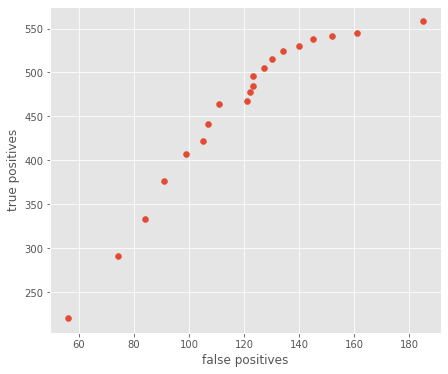

In [37]:
test_matches_arr = np.array(test_matches_min2)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_arr[:,1], test_matches_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

In [38]:
min_match = 6
cosine_thresholds = np.arange(0, 1, 0.05)

test_matches_min6 = []
for threshold in cosine_thresholds:
    print(f"Checking matches for cosine score > {threshold:.2f}")
    test_matches = []
    
    for ID in range(len(documents_query_classical)):
        if len(found_matches_classical[ID]) > 0:
            # Scenario 1: mass + sort by cosine
            df_select = found_matches_classical[ID][(found_matches_classical[ID]['mass_match'] == 1)
                                             & (found_matches_classical[ID]['cosine_score'] > threshold)
                                             & (found_matches_classical[ID]['cosine_matches'] >= min_match)]

            if df_select.shape[0] > 0:
                best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
                inchikey_selected = documents_library_classical[best_match_ID]._obj.get("inchikey")[:14]
                inchikey_query = documents_query_classical[ID]._obj.get("inchikey")[:14]

                best_bet = 1 * (inchikey_selected == inchikey_query)
            else:
                best_bet = -1 # meaning: not found
            test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_min6.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for cosine score > 0.00
Checking matches for cosine score > 0.05
Checking matches for cosine score > 0.10
Checking matches for cosine score > 0.15
Checking matches for cosine score > 0.20
Checking matches for cosine score > 0.25
Checking matches for cosine score > 0.30
Checking matches for cosine score > 0.35
Checking matches for cosine score > 0.40
Checking matches for cosine score > 0.45
Checking matches for cosine score > 0.50
Checking matches for cosine score > 0.55
Checking matches for cosine score > 0.60
Checking matches for cosine score > 0.65
Checking matches for cosine score > 0.70
Checking matches for cosine score > 0.75
Checking matches for cosine score > 0.80
Checking matches for cosine score > 0.85
Checking matches for cosine score > 0.90
Checking matches for cosine score > 0.95


Text(0, 0.5, 'true positives')

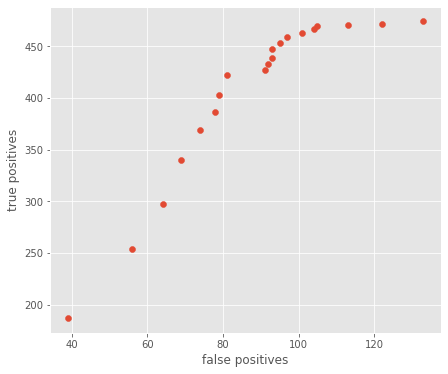

In [39]:
test_matches_arr = np.array(test_matches_min6)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_arr[:,1], test_matches_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

In [40]:
test_matches_s2v = []

cosine_thresholds = np.arange(0,1,0.05)

for threshold in cosine_thresholds:
    print(f"Checking matches for spec2vec score > {threshold:.2f}")
    test_matches = []
    
    for ID in range(len(documents_query_s2v)):

        # Scenario 2: mass + sort by Spec2Vec
        df_select = found_matches_s2v[ID][(found_matches_s2v[ID]['mass_match'] == 1)
                                      & (found_matches_s2v[ID]['s2v_score'] > threshold)]
        if df_select.shape[0] > 0:
            best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
            inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
            inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
            
            best_bet = 1 * (inchikey_selected == inchikey_query)
        else:
            best_bet = -1 # meaning: not found
        test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_s2v.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for spec2vec score > 0.00
Checking matches for spec2vec score > 0.05
Checking matches for spec2vec score > 0.10
Checking matches for spec2vec score > 0.15
Checking matches for spec2vec score > 0.20
Checking matches for spec2vec score > 0.25
Checking matches for spec2vec score > 0.30
Checking matches for spec2vec score > 0.35
Checking matches for spec2vec score > 0.40
Checking matches for spec2vec score > 0.45
Checking matches for spec2vec score > 0.50
Checking matches for spec2vec score > 0.55
Checking matches for spec2vec score > 0.60
Checking matches for spec2vec score > 0.65
Checking matches for spec2vec score > 0.70
Checking matches for spec2vec score > 0.75
Checking matches for spec2vec score > 0.80
Checking matches for spec2vec score > 0.85
Checking matches for spec2vec score > 0.90
Checking matches for spec2vec score > 0.95


Text(0, 0.5, 'true positives')

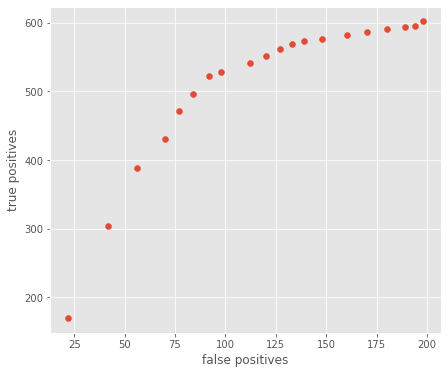

In [41]:
test_matches_s2v_arr = np.array(test_matches_s2v)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_s2v_arr[:,1], test_matches_s2v_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

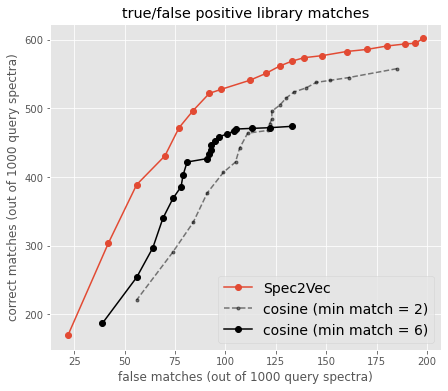

In [42]:
test_matches_min2_arr = np.array(test_matches_min2)
test_matches_min6_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.plot(test_matches_s2v_arr[:,1], test_matches_s2v_arr[:,0], 
         'o-', label='Spec2Vec')
plt.plot(test_matches_min2_arr[:,1], test_matches_min2_arr[:,0], 
         '.--', color='black', alpha=0.5, label='cosine (min match = 2)')
plt.plot(test_matches_min6_arr[:,1], test_matches_min6_arr[:,0], 
         'o-', color='black', label='cosine (min match = 6)')
plt.title('true/false positive library matches')
plt.legend(fontsize=14)
plt.xlabel('false matches (out of 1000 query spectra)')
plt.ylabel('correct matches (out of 1000 query spectra)')
plt.savefig('library_matching_true_false_positives_absolute_201125.pdf')

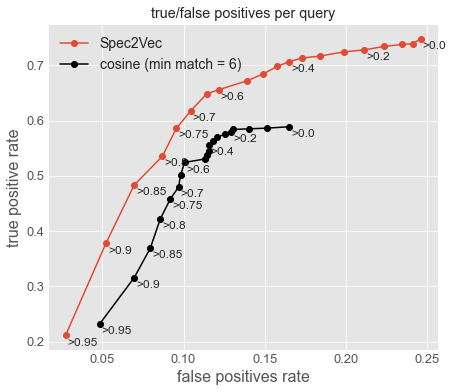

In [64]:
min_match = 6
#test_matches_cosine_arr = np.array(test_matches_ROC_min2)
test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,12,14,15,16,17,18,19]

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
num_max = np.sum(test_matches_arr[0,:])

plt.plot(test_matches_s2v_arr[:,1]/num_max, test_matches_s2v_arr[:,0]/num_max, 
         'o-', label='Spec2Vec')
plt.plot(test_matches_cosine_arr[:,1]/num_max, test_matches_cosine_arr[:,0]/num_max, 
         'o-', color='black', label='cosine (min match = {})'.format(min_match))
for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_s2v_arr[i,1]/num_max, test_matches_s2v_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_cosine_arr[i,1]/num_max, test_matches_cosine_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)

#plt.plot(test_matches_ROC_min2_arr[:,1]/num_max, test_matches_ROC_min2_arr[:,0]/num_max, 
#         '.--', color='black', alpha=0.5, label='cosine (min match = 2)')

plt.title('true/false positives per query')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('false positives rate', fontsize=16)
plt.ylabel('true positive rate', fontsize=16)
#plt.xlim([0, 0.3])
plt.savefig('library_matching_true_false_positives_labeled_201125.svg')

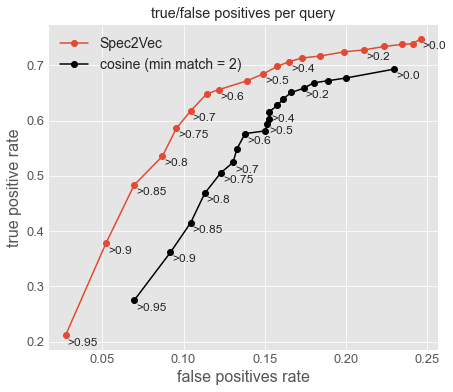

In [65]:
min_match = 2
test_matches_cosine_arr = np.array(test_matches_min2)
#test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,10,12,14,15,16,17,18,19]

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
num_max = np.sum(test_matches_arr[0,:])

plt.plot(test_matches_s2v_arr[:,1]/num_max, test_matches_s2v_arr[:,0]/num_max, 
         'o-', label='Spec2Vec')
plt.plot(test_matches_cosine_arr[:,1]/num_max, test_matches_cosine_arr[:,0]/num_max, 
         'o-', color='black', label='cosine (min match = {})'.format(min_match))
for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_s2v_arr[i,1]/num_max, test_matches_s2v_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_cosine_arr[i,1]/num_max, test_matches_cosine_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)

plt.title('true/false positives per query')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('false positives rate', fontsize=16)
plt.ylabel('true positive rate', fontsize=16)
#plt.xlim([0, 0.3])
plt.savefig('library_matching_true_false_positives_labeled_minmatch2_201125.svg')

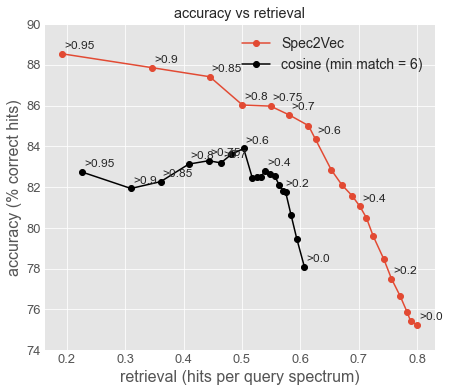

In [66]:
min_match=6
#test_matches_cosine_arr = np.array(test_matches_min2)
test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,12,14,15,16,17,18,19]

accuracy_s2v = 100 * test_matches_s2v_arr[:,0]/(test_matches_s2v_arr[:,0] + test_matches_s2v_arr[:,1])
accuracy_cosine = 100 * test_matches_cosine_arr[:,0]/(test_matches_cosine_arr[:,0] + test_matches_cosine_arr[:,1])

retrieval_s2v = (test_matches_s2v_arr[:,1] + test_matches_s2v_arr[:,0])/1000
retrieval_cosine = (test_matches_cosine_arr[:,1] + test_matches_cosine_arr[:,0])/1000

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.plot(retrieval_s2v, accuracy_s2v, 'o-', label='Spec2Vec')
plt.plot(retrieval_cosine, accuracy_cosine, 'o-', color="black", label='cosine (min match = {})'.format(min_match))

for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_s2v[i], accuracy_s2v[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_cosine[i], accuracy_cosine[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)

plt.title('accuracy vs retrieval')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim([74, 90])
plt.xlabel('retrieval (hits per query spectrum)', fontsize=16)
plt.ylabel('accuracy (% correct hits)', fontsize=16)
plt.savefig('library_matching_accuracy_vs_retrieval_201125.svg')

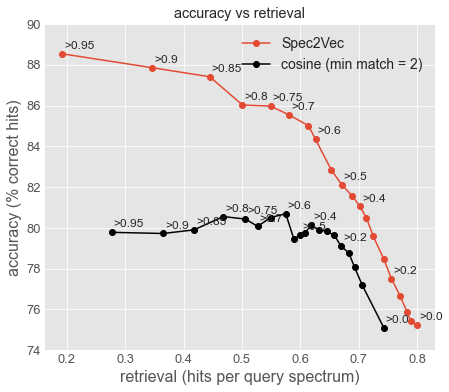

In [67]:
min_match=2
test_matches_cosine_arr = np.array(test_matches_min2)
#test_matches_cosine_arr = np.array(test_matches_min6)
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,10,12,14,15,16,17,18,19]

accuracy_s2v = 100 * test_matches_s2v_arr[:,0]/(test_matches_s2v_arr[:,0] + test_matches_s2v_arr[:,1])
accuracy_cosine = 100 * test_matches_cosine_arr[:,0]/(test_matches_cosine_arr[:,0] + test_matches_cosine_arr[:,1])

retrieval_s2v = (test_matches_s2v_arr[:,1] + test_matches_s2v_arr[:,0])/1000
retrieval_cosine = (test_matches_cosine_arr[:,1] + test_matches_cosine_arr[:,0])/1000

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.plot(retrieval_s2v, accuracy_s2v, 'o-', label='Spec2Vec')
plt.plot(retrieval_cosine, accuracy_cosine, 'o-', color="black", label='cosine (min match = {})'.format(min_match))

for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_s2v[i], accuracy_s2v[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)
        plt.annotate(">{:.2}".format(threshold),
                    (retrieval_cosine[i], accuracy_cosine[i]),
                    textcoords="offset points", xytext=(2, 5), fontsize=12)

plt.title('accuracy vs retrieval')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim([74, 90])
plt.xlabel('retrieval (hits per query spectrum)', fontsize=16)
plt.ylabel('accuracy (% correct hits)', fontsize=16)
plt.savefig('library_matching_accuracy_vs_retrieval_minmatch2_201125.svg')#pdf')